In [42]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [7]:
from network import Network, TargetNetwork
from layer import LowPassFilter

In [36]:
network = Network(force_self_prediction=True)
target_network = TargetNetwork()
    
network.load("saved")
    
dt = 0.1
lp_filter = LowPassFilter(dt, 3)

inputs = []
targets = []
outputs = []

for i in range(100):
    input_values, target_values = target_network.get_training_pair()
    for j in range(1000):
        filtered_input_values = lp_filter.process(input_values)
        inputs.append(filtered_input_values)
        network.set_input_firing_rate(filtered_input_values)
        network.update(dt)
        
        targets.append(target_values)
        outputs.append(network.layers[2].get_p_activation())
        
inputs = np.array(inputs)
targets = np.array(targets)
outputs = np.array(outputs)

weight loaded: saved/layer0.npz
weight loaded: saved/layer1.npz
loaded: saved


In [37]:
inputs.shape

(100000, 30)

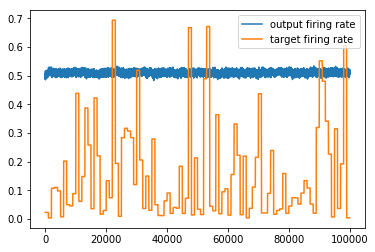

In [35]:
check_index = 8
plt.plot(outputs[:,check_index], label="output firing rate")
plt.plot(targets[:,check_index], label="target firing rate")
plt.legend()
plt.show()

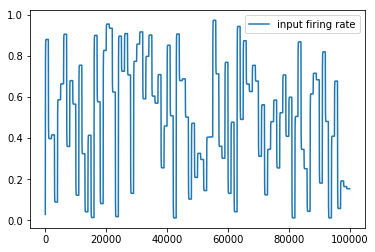

In [41]:
plt.plot(inputs[:,2], label="input firing rate")
plt.legend()
plt.show()

In [59]:
data_file_path = "saved/layer1.npz"
data = np.load(data_file_path)

w_pp_bu = data["w_pp_bu"]
w_pp_td = data["w_pp_td"]
w_ip    = data["w_ip"] # (10,20)
w_pi    = data["w_pi"] # (20,10)

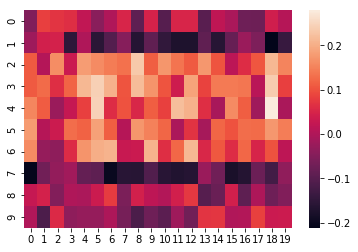

In [60]:
sns.heatmap(w_pp_bu)
plt.show()

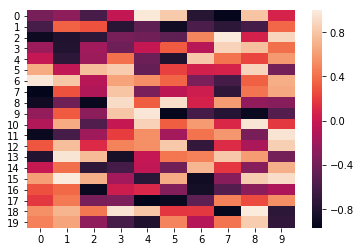

In [61]:
sns.heatmap(w_pp_td)
plt.show()

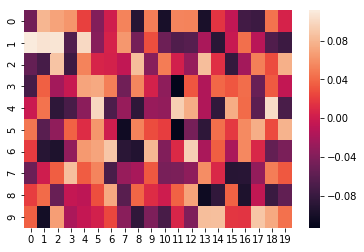

In [62]:
sns.heatmap(w_ip)
plt.show()

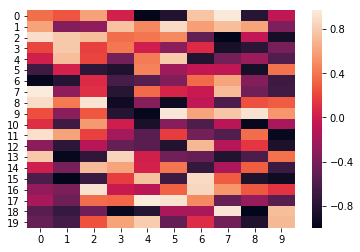

In [63]:
sns.heatmap(w_pi)
plt.show()

In [56]:
data_file_path = "saved/layer0.npz"
data = np.load(data_file_path)
w_pp_bu = data["w_pp_bu"]
w_pp_td = data["w_pp_td"]

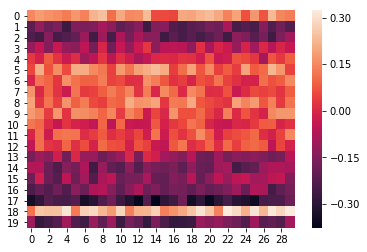

In [57]:
sns.heatmap(w_pp_bu)
plt.show()

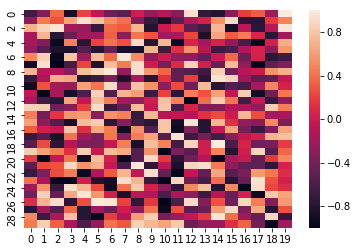

In [58]:
sns.heatmap(w_pp_td)
plt.show()